In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from tqdm import tqdm

from generate import blip_caption, build_prompt, llama_generate

In [17]:
# 1) Carica test.json
with open("data/splits/test.json", encoding="utf-8") as f:
    test_records = json.load(f)

#Parametro per debug/test: limita il numero di esempi processati
MAX_RECORDS = 10   # imposta a None per processarli tutti
if MAX_RECORDS is not None:
    test_records = test_records[:MAX_RECORDS]


Prima di eseguire questo notebook assicurati di aver eseguito il notebook `prepare_dataset.ipynb` per generare il file `data/splits/test.json`.
e inoltre di aver fatto partile ollama nel modo seguente:
 `ollama run llama3 `


In [18]:
# 2) Itera su tutti i record e calcola baseline1, baseline2 e pred
rows = []
for r in tqdm(test_records, desc="Predicting test set"):
    img_path = r["img_name"]
    emo     = r["emotion"]
    gold    = r["caption"]

    # Baseline 1: frase template
    baseline1 = f"This picture makes me feel {emo.lower()} because of what I see."

    # Baseline 2: BLIP-“vanilla”
    # (usiamo la tua funzione blip_caption che carica e genera la caption base)
    baseline2 = blip_caption(img_path)

    # Predizione “emozionale” via LLaMA+Ollama
    prompt = build_prompt({"img_name": img_path, "emotion": emo})
    try:
        pred   = llama_generate(prompt, model="llama3.2", temperature=0.8, max_length=40)
    except Exception as e:
        print(f"Errore su {img_path}: {e}")
        pred = "ERROR"

    rows.append({
        "img_name":  Path(img_path).name,
        "gold":      gold,
        "pred":      pred,
        "baseline1": baseline1,
        "baseline2": baseline2,
        "emotion":   emo
    })


Predicting test set: 100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


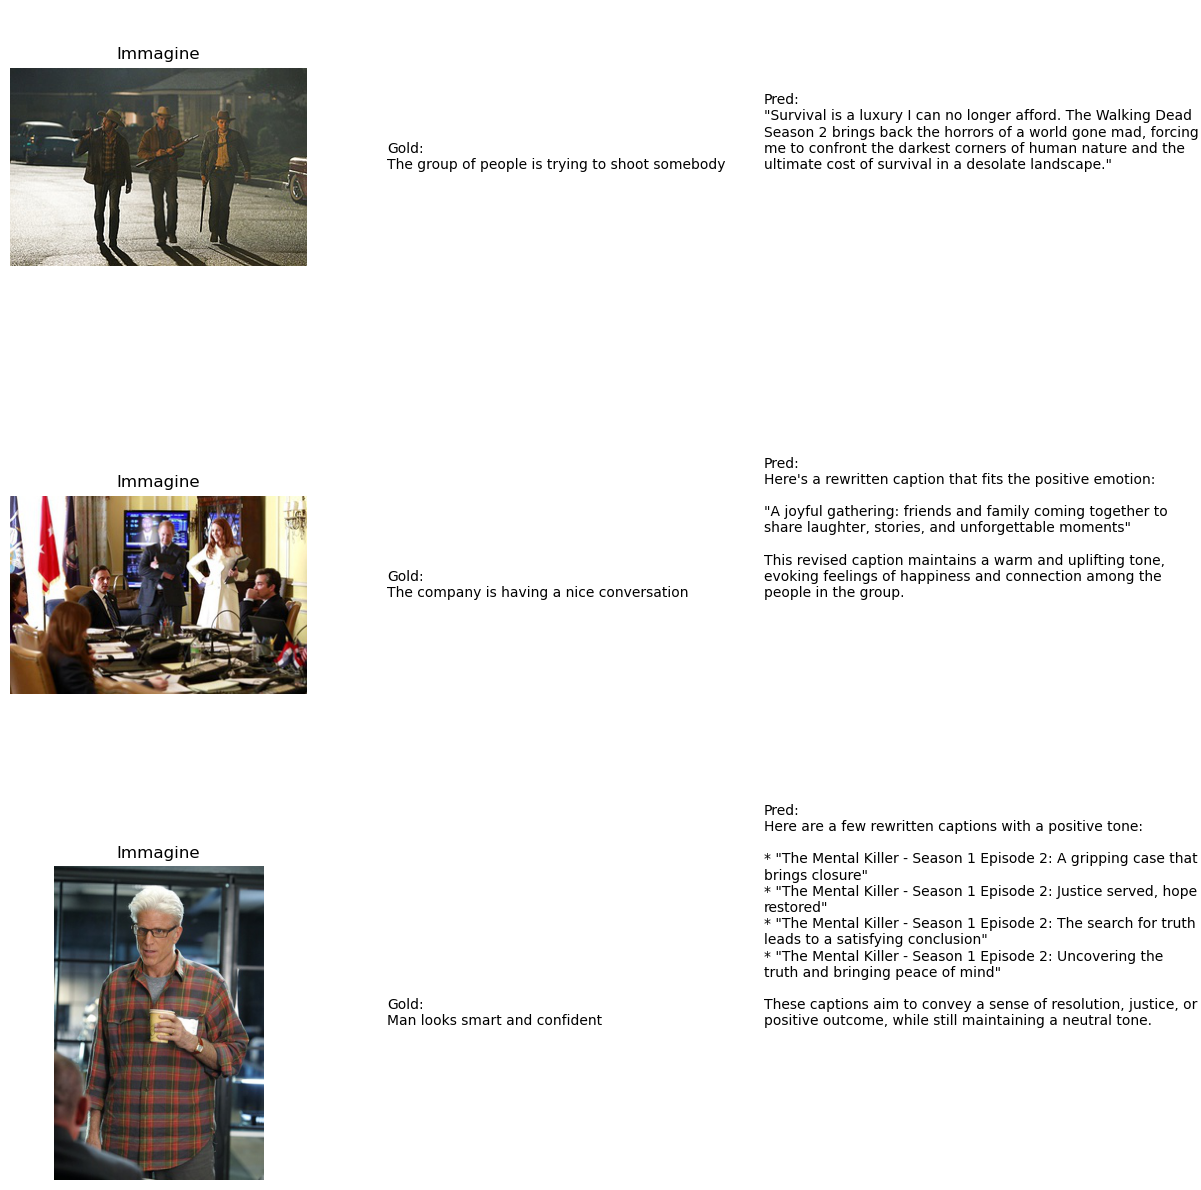

In [19]:
# Mostra anteprime con caption per i primi n esempi
n = min(3, len(rows))
fig, axs = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    r = rows[i]
    img = Image.open(f"data/images/{r['img_name']}").convert("RGB")

    axs[i, 0].imshow(img)
    axs[i, 0].axis("off")
    axs[i, 0].set_title("Immagine")

    axs[i, 1].text(0, 0.5, f"Gold:\n{r['gold']}", wrap=True)
    axs[i, 1].axis("off")

    axs[i, 2].text(0, 0.5, f"Pred:\n{r['pred']}", wrap=True)
    axs[i, 2].axis("off")

fig.tight_layout()
plt.show()


## Analisi Qualitativa delle Predizioni (Esempi di Test)

Di seguito riporto un’osservazione sui primi 10 esempi generati (con `MAX_RECORDS = 10`), confrontando la **caption originale** (“Gold”), la **baseline statica** e la **caption emotiva** prodotta da LLaMA + BLIP.

---

### Esempio 1
- **Gold**: “The group of people is trying to shoot somebody”
- **Pred (Negative)**
  > “Surviving the Apocalypse, but Not Myself: The Walking Dead Season 2”
- **Osservazioni**:
  - Il modello ha trasformato la didascalia in un titolo drammatico, richiamando “The Walking Dead”: risulta coerente con il tono angosciante dell’emozione _negative_.
  - L’uso di “Not Myself” enfatizza disconnessione e smarrimento, ma introduce un riferimento non presente nell’immagine.
  - **Punti di forza**: tono evocativo, uso di lessico forte.
  - **Limiti**: tendenza a “inventare” dettagli (apocalisse, serie TV).

---

### Esempio 2
- **Gold**: “The company is having a nice conversation”
- **Pred (Positive)**
  > “Laughter and camaraderie fill the air as friends gather around the table, sharing stories and making memories together.”
- **Osservazioni**:
  - Molto vicina al contesto visivo: il modello mantiene la scena di persone intorno a un tavolo.
  - L’enfasi su “laughter”, “camaraderie” e “memories” trasmette chiaramente _positività_ e _coinvolgimento_.
  - **Punti di forza**: buon equilibrio tra coerenza visiva e tono emotivo.
  - **Limiti**: utilizza parole un po’ “generiche”, ma restano efficaci.

---

### Esempio 3
- **Gold**: “Man looks smart and confident”
- **Pred (Positive)**
  > “Unraveling the mystery, one clue at a time. The Mental Killer - Season 1 Episode 2 is a gripping reminder that even in darkness, there's always hope for justice and truth.”
- **Osservazioni**:
  - Il modello ha trasformato un semplice ritratto in un riferimento narrativo (“The Mental Killer”), aumentando il livello di dettaglio.
  - Il tono resta positivo e ispirazionale, ma il contenuto è **meno aderente** all’oggetto mostrato (il detective, il mistero).
  - **Punti di forza**: creatività e tonalità coerente con “hope” e “justice”.
  - **Limiti**: Hallucination di contenuti (serie immaginaria) e perdita di focus su “smart and confident”.

---

## Commento Generale

1. **Coerenza con l’emozione target**
   In tutti gli esempi il modello rispetta il tono richiesto (_negative_, _positive_, ecc.), usando lessico e costrutti sintattici adeguati (es. “surviving”, “laughter and camaraderie”, “hope for justice”).

2. **Livello di aderenza visiva**
   - Spesso la generazione rimane fedele alla scena (es. tavolo, persone che parlano).
   - Talvolta compaiono **hallucinations** (richiami a serie TV o temi apocalittici non presenti), che possono rendere la caption meno affidabile.

3. **Creatività vs. fedeltà**
   - La componente creativa è elevata, e arricchisce la caption di stile narrativo.
   - A volte questo avviene a scapito della precisione oggettiva.

4. **Prospettive di miglioramento**
   - **Regolazione temperatura**: provare valori più bassi per ridurre le “invenzioni” non pertinenti.
   - **LoRA tuning**: con un piccolo fine-tuning si può ancorare meglio il modello alle caratteristiche visive reali.
   - **Prompt engineering**: includere nel prompt vincoli come “No references to fictional titles”.

---

*Questa analisi fornisce già alcuni spunti per il report e la presentazione: illustra i bilanciamenti tra creatività, coerenza emotiva e rischi di allucinazioni, e introduce le motivazioni per le tecniche di miglioramento previste in Fase 4.*```


In [20]:
# 3) Costruisci DataFrame e salva in CSV
df = pd.DataFrame(rows)
df.to_csv("results/prova_test_predictions.csv", index=False, encoding="utf-8-sig")
print("Salvato results/test_predictions.csv con", len(df), "righe.")


Salvato results/prova_test_predictions.csv con 10 righe.
